In [1]:
import math
import os
import subprocess
import uuid

from IPython.display import set_matplotlib_formats
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx

from mediawords.db import *

PLATFORM_MEDIA_IDS =[18362, 18346, 18370, 61164, 269331, 73449, 62926, 21936, 5816, 4429, 20448, 67324, 351789, 22299, 135076, 25373]

    
def add_partisan_retweet_to_snapshot_media(db, timespans_id, media):
    label = 'partisan_retweet'

    partisan_tags = db.query(
        """
select dmtm.*, dt.tag
    from snap.media_tags_map dmtm
        join tags dt on ( dmtm.tags_id = dt.tags_id )
        join tag_sets dts on ( dts.tag_sets_id = dt.tag_sets_id )
        join timespans t using ( snapshots_id )
    where
        dts.name = 'retweet_partisanship_2016_count_10' and
        t.timespans_id = %(a)s
        """,
        {'a': timespans_id}
    ).hashes()

    partisan_map = {pt['media_id']: pt['tag'] for pt in partisan_tags}

    for medium in media:
        medium[label] = partisan_map.get(medium['media_id'], 'null')
        
def get_media_network(db, timespans_id):
    """Get a network of media and edges for the topic."""
    media = db.query(
        """
        select m.media_id, m.name, mlc.media_inlink_count
            from media m
                join snap.medium_link_counts mlc using ( media_id )
            where
                mlc.timespans_id = %(a)s
        """,
        {'a': timespans_id}
    ).hashes()
    
    medium_links = db.query(
        "select * from snap.medium_links where timespans_id = %(a)s",
        {'a': timespans_id}
    ).hashes()
    
    media_lookup = {m['media_id']: m for m in media}

    for medium in media:
        media_lookup[medium['media_id']] = medium
        
    for medium_link in medium_links:
        medium = media_lookup[medium_link['source_media_id']]
        medium.setdefault('links', [])
        medium['links'].append(medium_link)
        
    add_partisan_retweet_to_snapshot_media(db, timespans_id, media)
        
    return media

def get_media_graph(db, media):
    """Get a networkx graph describing the media network of the topic."""
    media = get_media_network(db, timespans_id)
    
    graph = nx.Graph()
    
    [graph.add_node(m['media_id']) for m in media]
    
    media_lookup = {m['media_id']: m for m in media}

    nx.set_node_attributes(graph, media_lookup)

    for medium in media:
        if 'links' in medium:
            for e in medium['links']:
                graph.add_edge(
                    e['source_media_id'],
                    e['ref_media_id'],
                    weight=e['link_count']
                )
            
    return graph
    

db = connect_to_db()
# corona
#timespans_id = 883849
# election web
timespans_id = 883131

media = get_media_network(db, timespans_id)
graph = get_media_graph(db, media)

print(media[0])

len(graph.nodes)


INFO mediawords.db.result.result: Slow query (1 seconds): select m.media_id, m.name, mlc.media_inlink_count from media m join [...], ({'a': 883131},)
INFO mediawords.db.result.result: Slow query (2 seconds): select * from snap.medium_links where timespans_id = %(a)s, ({'a': 883131},)


{'media_id': 106400, 'name': 'hypable.com', 'media_inlink_count': 1, 'partisan_retweet': 'null'}


83233

In [2]:
print(graph)
graphs = nx.connected_components(graph)
graphs = sorted(graphs, key=len, reverse=True)

graph = graph.subgraph(graphs[0])
    
len(graph.nodes)


69757

In [3]:
platform_lookup = {id: True for id in PLATFORM_MEDIA_IDS}
include_nodes = []

for node in graph.nodes():
    if node not in platform_lookup:
        include_nodes.append(node)

graph = graph.subgraph(include_nodes)

In [4]:
def run_fa2_layout(graph):
    input_file = "/tmp/media-%s.gexf" % uuid.uuid4().hex
    output_template = "/tmp/media-%s" % uuid.uuid4().hex
    output_file = "%s.txt" % output_template
    
    export_graph = graph.copy()
    for node in export_graph.nodes(data=True):
        for key in list(node[1].keys()):
            del node[1][key]

    nx.write_gexf(export_graph, input_file)
    
    print("running layout...")
        
    p = subprocess.Popen(
        [
            "/usr/bin/java",
            "-Djava.awt.headless=true",
            "-Xmx8g", 
            "-cp", "/hroberts/tmp/java-fa2/forceatlas2.jar:/hroberts/tmp/java-fa2/gephi-toolkit-0.9.2-all.jar",
            "kco.forceatlas2.Main",
            "--input", input_file,
            #"--nsteps", "1000",
            "--targetChangePerNode", "0.5",
            "--output", output_template,
            "--directed",
            "--2d"
        ],
        stdout=subprocess.PIPE,
        bufsize=1,
        universal_newlines=True
    )

    for line in p.stdout:
        print(line, end='')
        
    f = open(output_file)
    lines = f.readlines()
    
    del lines[0]
    
    positions = {}
    for line in lines:
        (i, x, y) = [float(i) for i in line.split()]
        positions[i] = (x, y)
        
    os.remove(input_file)
    os.remove(output_file)
        
    return positions
    
positions = run_fa2_layout(graph)

running layout...
100 iterations, change_per_node = 17.601007659796796
200 iterations, change_per_node = 4.873793535935486
300 iterations, change_per_node = 3.195461637182124
400 iterations, change_per_node = 2.549947688761612
500 iterations, change_per_node = 1.9350477772188697
600 iterations, change_per_node = 1.2557033147612955
700 iterations, change_per_node = 0.6970246088434845
800 iterations, change_per_node = 0.6464079344426138
Finished in 812 iterations, change_per_node = 0.4776706674539728
Time = 219.833s


69743
1000


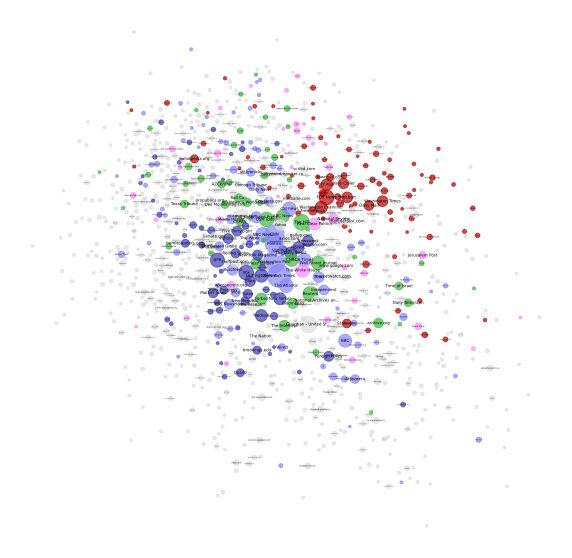

In [5]:
PARTISAN_COLORS = {
    'left': '#4040bb',
    'center_left': '#8888FF',
    'center': '#40BB40',
    'center_right': '#FF88FF',
    'right': '#BB0404',
    'null': '#DDDDDD'
}

def get_colors(graph):
    partisan_retweet = nx.get_node_attributes(graph, 'partisan_retweet')
    color_table = [PARTISAN_COLORS[partisan_retweet[n]] for n in graph.nodes]
    
    return color_table

def get_node_sizes(graph, attribute, scale):
    values = nx.get_node_attributes(graph, attribute).values()
        
    max_value = max(values)
        
    return [(v / max_value) * scale for v in values]

def get_display_subgraph_by_attribute(graph, attribute, num_nodes):
    """Get a subgraph with only the top num_nodes nodes by attribute."""
    nodes_with_values = nx.get_node_attributes(graph, attribute).items()
    
    sorted_nodes_with_values = sorted(nodes_with_values, key=lambda n: n[1], reverse=True)
    
    include_node_ids = [n[0] for n in sorted_nodes_with_values[0:num_nodes]]
    
    include_nodes = []
    for node in graph.nodes():
        if node in include_node_ids:
            include_nodes.append(node)
    
    return graph.subgraph(include_nodes)

def prune_graph_by_distance(graph, positions):
    """Get a subgraph with far flung nodes pruned.
    
    Many graphs end up with a few far flung nodes that distort the whole map.  This
    function computes the average distances from the center of the graph and removes
    any nodes that are more than 2.5x the average distance.
    """
    center_x = sum([positions[n][0] for n in graph.nodes()]) / len(graph.nodes())
    center_y = sum([positions[n][1] for n in graph.nodes()]) / len(graph.nodes())
    
    distance_map = {}
    for node in graph.nodes():
        node_x = positions[node][0]
        node_y = positions[node][1]
        distance = math.sqrt((node_x - center_x)**2 + (node_y - center_y)**2)
        distance_map[node] = distance
    
    average_distance = sum(distance_map.values())/len(distance_map.values())
    max_distance = average_distance * 2.5
    
    include_nodes = []
    for node in graph.nodes():
        if distance_map[node] <= max_distance:
            include_nodes.append(node)
            
    return graph.subgraph(include_nodes) 

def get_labels_by_attribute(graph, label_attribute, rank_attribute, iteration, num_labels):
    """Get the top num_labels labels according to rank_attribute."""
    offset = iteration * num_labels
    
    ranks = nx.get_node_attributes(graph, rank_attribute)
    
    nodes = [n[0] for n in sorted(ranks.items(), key=lambda x: x[1], reverse=True)][offset:offset + num_labels]
    
    labels = nx.get_node_attributes(graph, label_attribute)
    
    for k in labels.keys():
        labels[k] = labels[k][0:20] + '...' if len(labels[k]) > 20 else labels[k]
    
    return {n: labels[n] for n in nodes}

def draw_labels(graph):
    num_cohorts = 20
    num_labeled_cohorts = 4
    cohort_size = int(len(graph.nodes()) / num_cohorts)
    for i in range(num_labeled_cohorts):
        labels = get_labels_by_attribute(graph, 'name', 'media_inlink_count', i, 100)
        nx.draw_networkx_labels(
            G=graph,
            pos=positions,
            labels=labels,
            font_size=4 / (i + 1),
            font_weight='normal'
        )


def draw_graph(graph, positions):
    
    graph = get_display_subgraph_by_attribute(graph, 'media_inlink_count', 1000)
    graph = prune_graph_by_distance(graph, positions)
        
    include_positions = {n: positions[n] for n in graph.nodes}
    
    print(len(positions.keys()))
    print(len(include_positions.keys()))
        
    color_table = get_colors(graph)
    
    max_size = math.sqrt(len(positions)) * 2
    node_sizes = get_node_sizes(graph, 'media_inlink_count', max_size)

    fig = plt.figure(figsize=(10,10))

    nx.draw_networkx_nodes(
        G=graph,
        pos=include_positions,
        node_size=node_sizes,
        with_labels=False,
        node_color=color_table,
        alpha=0.7
    )
    
    draw_labels(graph)
    
    #nx.draw_networkx_edges(graph, positions, edge_color="green", alpha=0.05)

    fig.set_facecolor('#FFFFFF')

    plt.axis('off')
    set_matplotlib_formats('svg')
    plt.show()
    
draw_graph(graph, positions)
